In [1]:
# Scrape LCS data across all regions
# Christian Hallas, 6/18/2016

# League IDs
# 2 - NA LCS
# 3 - EU LCS
# 4 - NA CS
# 5 - NA EU
# 6 - LCK
# 7 - LPL
# 8 - LMS
# 9 - Worlds 2015
# 10 - MSI 2016

leagueIds = [2,3,4,5,6,7,8,9,10]

In [187]:
from operator import itemgetter
import cPickle as pickle
import matplotlib
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.cross_validation import StratifiedKFold, PredefinedSplit, cross_val_score
from sklearn.grid_search import GridSearchCV
import json
import requests
import time
import numpy as np
import pandas as pd
import urllib2
import json

In [3]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def try_scrape_stats(url):
    print url
    while True:
        try:
            req = urllib2.Request(url, headers={'User-Agent' : "Magic Browser"})
            r = urllib2.urlopen(req)
            data = json.load(r)
            if r.getcode() == 200:
                print "suc",
                break
        except Exception as inst:
            print inst
    return data

In [5]:
def scrapeLeague(leagueId):
    ext = '?league=' + str(leagueId)
    data = try_scrape_stats(url+ext)
    return data

In [6]:
# Define data structures to keep the games
leagues = {}

In [12]:
# Scrape all preliminary sites
url = 'http://api.lolesports.com/api/v2/highlanderTournaments'
data = []
for leagueId in leagueIds:
    data.append(scrapeLeague(leagueId))

 http://api.lolesports.com/api/v2/highlanderTournaments?league=2
suc http://api.lolesports.com/api/v2/highlanderTournaments?league=3
suc http://api.lolesports.com/api/v2/highlanderTournaments?league=4
suc http://api.lolesports.com/api/v2/highlanderTournaments?league=5
suc http://api.lolesports.com/api/v2/highlanderTournaments?league=6
suc http://api.lolesports.com/api/v2/highlanderTournaments?league=7
suc http://api.lolesports.com/api/v2/highlanderTournaments?league=8
suc http://api.lolesports.com/api/v2/highlanderTournaments?league=9
suc http://api.lolesports.com/api/v2/highlanderTournaments?league=10
suc


In [13]:
# Find the match identifiers
matches = {}
for dat in data:
    for league in dat['highlanderTournaments']:
        league_id, league_name = league['id'], league['title']
        for s, v in league['brackets'].iteritems():
            for t, m in v['matches'].iteritems():
                for p, q in m['games'].iteritems():
                    match_id = t
                    try:
                        game_id = q['gameId']
                        game_realm = q['gameRealm']
                        idd = q['id']

                        if match_id not in matches:
                            matches[match_id] = []

                        matches[match_id].append({'game_id':game_id, 
                                                    'game_realm':game_realm,  
                                                    'league_name':league_name,
                                                    'league_id':league_id,
                                                    'idd':idd})
                    except KeyError:
                        pass

        # Create a dictionary for the league
        leagues[league_name] = {}

In [1032]:
def try_scrape(s, url, hdr, payload):
    while True:
        try:
            r = s.get(url, headers=hdr, params=payload)
            if r.status_code == 200:
                break
        except Exception as inst:
            print inst
    return r.json()

In [1033]:
# Find the gamehashes for games
s = requests.Session()
url = 'http://api.lolesports.com/api/v2/highlanderMatchDetails'
for match, games in matches.iteritems():
    match_id = match
    for game in games:
        league_id = game['league_id']
        idd = str(game['idd'])
        
        payload = {'tournamentId':str(league_id), 'matchId':str(match_id)}
        hdr = {'User-Agent' : "Magic Browser"}
        data = try_scrape(s, url, hdr, payload)
        
        print url + '?tournamentId=' + str(league_id) + '&matchId=' + str(match_id)
        
        gamehash = [x['gameHash'] for x in data['gameIdMappings'] if idd == x['id']][0]
        game['gamehash'] = gamehash
        
        try:
            gametime = data['scheduleItems'][0]['scheduledTime']
            game['gametime'] = gametime
        except IndexError:
            pass

http://api.lolesports.com/api/v2/highlanderMatchDetails?tournamentId=739fc707-a686-4e49-9209-e16a80fd1655&matchId=4403d39e-f613-48a1-b3c7-c8b9479f531f
http://api.lolesports.com/api/v2/highlanderMatchDetails?tournamentId=f7afa181-4580-48c0-af26-4b3d70fe21eb&matchId=fdd80e07-e221-4240-a582-cbc9056075ed
http://api.lolesports.com/api/v2/highlanderMatchDetails?tournamentId=f7afa181-4580-48c0-af26-4b3d70fe21eb&matchId=fdd80e07-e221-4240-a582-cbc9056075ed
http://api.lolesports.com/api/v2/highlanderMatchDetails?tournamentId=739fc707-a686-4e49-9209-e16a80fd1655&matchId=16ef4750-d7b6-410e-b16f-f1b248d38a3e
http://api.lolesports.com/api/v2/highlanderMatchDetails?tournamentId=739fc707-a686-4e49-9209-e16a80fd1655&matchId=16ef4750-d7b6-410e-b16f-f1b248d38a3e
http://api.lolesports.com/api/v2/highlanderMatchDetails?tournamentId=739fc707-a686-4e49-9209-e16a80fd1655&matchId=16ef4750-d7b6-410e-b16f-f1b248d38a3e
http://api.lolesports.com/api/v2/highlanderMatchDetails?tournamentId=739fc707-a686-4e49-9209-e

In [1]:
# pickle.dump(matches, open("matches.p", "wb" ))
matches = pickle.load(open("matches.p", "rb"))

NameError: name 'pickle' is not defined

In [16]:
# Put stats data into a dataframe that's nicer to work with
def dataframe_stats(data):
    
    tl = ['win',
          'firstDragon', 'dragonKills', 'firstTower', 'towerKills', 'firstBaron', 'baronKills', 'firstInhibitor', 'inhibitorKills']
    tstats = []
    
    # Team data
    teams = data['teams']
    t1 = list(itemgetter(*tl)(teams[0]))
    t2 = list(itemgetter(*tl)(teams[1]))
    tstats.append(t1)
    tstats.append(t2)
    
    # Did not include 'firstBloodAssist' as it seems to be buggy (they are ALL 'false')
    pl = ['kills', 'deaths','assists', 
          'goldEarned',
          'firstBloodKill', 'firstTowerKill', 'firstTowerAssist',
          'wardsPlaced', 'wardsKilled', 'sightWardsBoughtInGame',
          'totalDamageDealtToChampions','physicalDamageDealtToChampions','magicDamageDealtToChampions','totalTimeCrowdControlDealt', 
          'totalDamageTaken',
          'totalMinionsKilled','neutralMinionsKilled',
          'champLevel',
          'participantId']
    pl_t = ['goldPerMinDeltas', 'creepsPerMinDeltas', 'xpPerMinDeltas', 'damageTakenPerMinDeltas']
    pstats = []

    # Players data
    players = data['participants']
    for i in range(10):
        p = list(itemgetter(*pl)(players[i]['stats']))
        pt = list(itemgetter(*pl_t)(players[i]['timeline']))
        pstats.append(p+pt+[players[i]['championId']])
        
    tindex = ['t1', 't2']
    pindex = [x + 1 for x in range(10)]
    
    tstats = pd.DataFrame(tstats, columns=tl, index=tindex)
    pstats = pd.DataFrame(pstats, columns=pl+pl_t+['championId'], index=pindex)
    
    # Get players in the game
    participants = data['participantIdentities']
    
    # Add team names
    team_names = pd.DataFrame([x['player']['summonerName'].split(" ")[0] for x in participants][4:6],
                              columns=['teamName'], index=tindex)
    tstats = pd.merge(tstats, team_names, left_index=True, right_index=True)
    
    # Add participant names
    part_names = pd.DataFrame([[x['participantId'], x['player']['summonerName']] for x in participants],
                              columns=['participantId', 'summonerName'])
    pstats = pd.merge(pstats, part_names, on='participantId', how='left')
    
    return (tstats, pstats)

In [17]:
# Stats

url = 'https://acs.leagueoflegends.com/v1/stats/'
for match, games in matches.iteritems():
    for game in games:
        league_name = game['league_name']
        game_id = game['game_id']
        ext = 'game/' + str(game['game_realm']) + '/' + str(game_id).strip() + '?gameHash=' + str(game['gamehash'])
        data = try_scrape_stats(url+ext)
        
        if match not in leagues[league_name]:
            leagues[league_name][match] = {}
        
        if 'gametime' in game:
            leagues[league_name][match][game_id] = {}
            leagues[league_name][match][game_id]['gametime'] = game['gametime']
            leagues[league_name][match][game_id]['team'] = dataframe_stats(data)[0]
            leagues[league_name][match][game_id]['players'] = dataframe_stats(data)[1]
            leagues[league_name][match][game_id]['gametime'] = game['gametime']
            leagues[league_name][match][game_id]['game_id'] = game['game_id']

https://acs.leagueoflegends.com/v1/stats/game/TRLH1/1001510234?gameHash=8108b30126177b06
suc https://acs.leagueoflegends.com/v1/stats/game/TRLH3/1001240023?gameHash=464142d4bac6e0e8
suc https://acs.leagueoflegends.com/v1/stats/game/TRLH1/1001570147?gameHash=feacf99dfe77118f
suc https://acs.leagueoflegends.com/v1/stats/game/TRLH1/1001750143?gameHash=3ef0fd7649844cc8
suc https://acs.leagueoflegends.com/v1/stats/game/TRLH1/1001750142?gameHash=a4dc5cd727f14aa8
suc https://acs.leagueoflegends.com/v1/stats/game/TRLH1/1001750135?gameHash=7aa05375d72c2d51
suc https://acs.leagueoflegends.com/v1/stats/game/TRLH3/1001220096?gameHash=898e47758375b6fb
suc https://acs.leagueoflegends.com/v1/stats/game/TRLH3/1001220027?gameHash=fae2ff9ffc3f37c8
suc https://acs.leagueoflegends.com/v1/stats/game/TRLH1/1001800169?gameHash=f257efe929c1ab2e
suc https://acs.leagueoflegends.com/v1/stats/game/TRLH1/1001800167?gameHash=68c7f0c738fefb67
suc https://acs.leagueoflegends.com/v1/stats/game/TRLH1/1001800151?gameHas

In [18]:
# Timelines

url = 'https://acs.leagueoflegends.com/v1/stats/'
for match, games in matches.iteritems():
    for game in games:
        league_name = game['league_name']
        game_id = game['game_id']
        
        frames = []
        events = []

        ext = 'game/' + str(game['game_realm']) + '/' + str(game['game_id']).strip() + '/timeline?gameHash=' + str(game['gamehash'])
        data = try_scrape_stats(url+ext)
        
        for desc, frames_d in data.iteritems():
            
            if desc == 'frameInterval':
                frameInterval = frames_d

            else:
                frames = []
                
                for frame in frames_d:

                    timestamp = frame['timestamp']
                    par_frame = frame['participantFrames']

                    fl = ['totalGold', 'participantId', 'level', 'minionsKilled', 'position', 'xp', 'jungleMinionsKilled']

                    par_ids = [str(x + 1) for x in range(10)]
                    par_frames_d = list(itemgetter(*par_ids)(par_frame))
                    par_frames_d = [list(itemgetter(*fl)(x)) + [timestamp] for x in par_frames_d]
                    frames.append(pd.DataFrame(par_frames_d, columns=fl+['timestamp']))
                    
                    events.append(pd.DataFrame(frame['events']))
        
        if 'gametime' in game:
            leagues[league_name][match][game_id]['frames'] = frames
            leagues[league_name][match][game_id]['events'] = events
          

https://acs.leagueoflegends.com/v1/stats/game/TRLH1/1001510234/timeline?gameHash=8108b30126177b06
suc https://acs.leagueoflegends.com/v1/stats/game/TRLH3/1001240023/timeline?gameHash=464142d4bac6e0e8
suc https://acs.leagueoflegends.com/v1/stats/game/TRLH1/1001570147/timeline?gameHash=feacf99dfe77118f
suc https://acs.leagueoflegends.com/v1/stats/game/TRLH1/1001750143/timeline?gameHash=3ef0fd7649844cc8
suc https://acs.leagueoflegends.com/v1/stats/game/TRLH1/1001750142/timeline?gameHash=a4dc5cd727f14aa8
suc https://acs.leagueoflegends.com/v1/stats/game/TRLH1/1001750135/timeline?gameHash=7aa05375d72c2d51
suc https://acs.leagueoflegends.com/v1/stats/game/TRLH3/1001220096/timeline?gameHash=898e47758375b6fb
suc https://acs.leagueoflegends.com/v1/stats/game/TRLH3/1001220027/timeline?gameHash=fae2ff9ffc3f37c8
suc https://acs.leagueoflegends.com/v1/stats/game/TRLH1/1001800169/timeline?gameHash=f257efe929c1ab2e
suc https://acs.leagueoflegends.com/v1/stats/game/TRLH1/1001800167/timeline?gameHash=6

In [19]:
summoners = []

for _, league in leagues.iteritems():
    for _, matches in league.iteritems():
        for _, games in matches.iteritems():
            summoners_add = list(games['players']['summonerName'])
            summoners = summoners + summoners_add

In [20]:
# Formats a summoner name (e.g., 'TL Piglet' -> 'piglet')
def format_sum_name(sum_name):
    sum_name = sum_name[3:].lower().split(' ')
    return x[0] if x[0] != '' else x[1]

split_list = [x[3:].lower().split(' ') for x in list(set(summoners))]
summoner_list = pd.DataFrame([x[0] if x[0] != '' else x[1] for x in split_list]).drop_duplicates()

In [4]:
# pickle.dump(leagues, open("league_data.p", "wb" ))
leagues = pickle.load(open("league_data.p", "rb"))

In [6]:
leagues_to_train = ['na_2016_spring','eu_2016_spring','na_2016_summer','eu_2016_summer']

In [80]:
all_leagues = [x for x, _ in leagues.iteritems()]

In [92]:
# Get data

X = []
Y = []

for league_name, league in leagues.iteritems():
    if league_name in all_leagues:
        print league_name
        for match_id, matches in league.iteritems():
            print match_id
            for game_id, game in matches.iteritems():
                print game_id
                break
                
                team = game['team']
                players = game['players']
                date = game['gametime']
                frames = game['frames']
                events = game['events']
                league = league_name
                
                gametime = float(frames[-1]['timestamp'].max())
                
                stats = []
                
                # Team-specific stats
                for i in [0,1]:
                    
                    # Set indices
                    i1, i2 = i*5, (i+1)*5
                    
                    # Calculate all stats that are used in calculating other stats
                    kills = sum(players['kills'][i1:i2])
                    
                    # Get number of turrets destroyed
                    tur = pd.DataFrame()
                    for event in events:
                        try:
                            turret_events = event[event['towerType'].astype(str).str.contains("TURRET")]
                            if not turret_events.empty:
                                if i == 0:
                                    tur = tur.append(turret_events.query('teamId == 200'), ignore_index=True)
                                else:
                                    tur = tur.append(turret_events.query('teamId == 100'), ignore_index=True)
                        except:
                            pass
                    tur = tur.shape[0]
                    
                    # Calculate the integral of the gold difference
                    gold_diffs = []
                    for frame in frames:
                        if i == 0:
                            gold_diffs = gold_diffs + [frame[0:5]['totalGold'].sum() - frame[5:]['totalGold'].sum()]
                        else:
                            gold_diffs = gold_diffs + [frame[5:]['totalGold'].sum() - frame[0:5]['totalGold'].sum()]
                    
                    gold_diff_int = sum(gold_diffs)
                    gold_diff_var = np.sqrt(np.var(gold_diffs))
                    
                    # Append all stats to the stats data
                    stats.append([
                            team['dragonKills'][i],
                            team['baronKills'][i],
                            team['inhibitorKills'][i],
                            1 if team['win'][i] == 'Win' else 0,
                            gold_diff_int,
                            kills * 1000 * 60.0 / gametime,
                            sum(players['assists'][i1:i2]) * 1000 * 60.0 / gametime,
                            sum(players['deaths'][i1:i2]) * 1000 * 60.0 / gametime,
                            sum(players['totalDamageDealtToChampions'][i1:i2]),
                            sum([x['0-10'] for x in players['creepsPerMinDeltas'][i1:i2]]),
                            1 if kills == 0 else (players['kills'][i1] + players['assists'][i1]) / float(kills),
                            1 if kills == 0 else (players['kills'][i1+1] + players['assists'][i1+1]) / float(kills),
                            1 if kills == 0 else (players['kills'][i1+2] + players['assists'][i1+2]) / float(kills),
                            1 if kills == 0 else (players['kills'][i1+3] + players['assists'][i1+3]) / float(kills),
                            1 if kills == 0 else (players['kills'][i1+4] + players['assists'][i1+4]) / float(kills),
                            tur,
                            gold_diff_var
                    ])
                
                # Flatten the stats to get a row of stats
                stats = stats[0] + stats[1]
                
                # Give the stats names
                stat_names = ['drag_kills','baron_kills','inhib_kills','win','gold_diff_int','kills','assists','deaths',
                              'total_dmg','cs_per_min','kp_top','kp_jgl','kp_mid','kp_adc','kp_sup','tur','gold_diff_var']
                stat_names = ['t1_' + x for x in stat_names] + ['t2_' + x for x in stat_names]
                stat_names_ = ['t1_id','t2_id'] + ['date','game_id','match_id','league_name','outcome'] + stat_names
                
                # Alter current team saved stats
                t1_team_id = team['teamName'][0]
                t2_team_id = team['teamName'][1]
                
                X_app = []
                
                # Append the team IDs
                X_app.append(t1_team_id)
                X_app.append(t2_team_id)
                
                # Append date of the game
                X_app.append(pd.to_datetime(date))
                
                # Append game ID and league name
                X_app.append(game['game_id'])
                X_app.append(match_id)
                X_app.append(league_name)
                
                # Append the target variable
                t = 1 if team['win'][0] == 'Win' else 0
                X_app.append(t)
                
                # Append stats
                X_app = X_app + stats
                
                X.append(X_app)
            break


lms_2016_spring
d31c8c00-7228-401f-87ad-ae3ab02f9395
590030
lck_2016_summer
a26a5096-f1a3-4cc2-9ff2-4af9ade591e0
1080590
na_2015_summer_playoffs
8c8ab8a2-12c2-4a52-af6e-135f5d106a0c
1001360067
nacs_2016_spring
17e9e964-8cfd-46b9-920b-ac0b7139f117
880082
na_2015_regionals
3294f2ca-0b24-4752-b6b3-177b362c2c16
1001370019
eu_2016_summer
6a4fff62-375a-4342-acdb-78a0d7a91bff
1001690044
lck_2016_spring
53854d31-b388-4397-9873-2072f2866e06
890110
lpl_2016_summer
nacs_2016_summer
342985f1-3412-45f2-90d6-873e96b27742
1060096
world_championship_2015
ac047b2b-89d0-425a-9ca9-5659ad9ad48a
1001380841
na_2016_summer
9adf1838-2d93-4fa6-acc0-27728bd90dcd
1001790225
eu_2015_regionals
357320c5-b8d9-469f-8c95-1c74826e4f94
1001310030
eucs_2016_summer
098a6e23-b26f-4f14-b8ed-903183f043a6
1001310067
eu_2015_summer
a49cdce3-d055-4848-9202-66b9806bf17d
1001220096
lpl_2016_spring
na_2016_spring
4403d39e-f613-48a1-b3c7-c8b9479f531f
1001510234
eu_2015_summer_playoffs
317349d3-2759-4605-9819-fb20f8f099d0
1001290055

In [87]:
X_ = pd.DataFrame(X, columns=stat_names_).sort_values(by=['date','game_id'])

In [253]:
def adjust_stat(stat, team1, team2, stat_index, adjust_index, average):
    if stat == 0:
        teams[league_name][team1][stat_index].append(0)
    else:
        teams[league_name][team1][stat_index].append(pred * average / np.sum(weight_stat(teams[league_name][team2][adjust_index])))

In [705]:
def weight_stat(stat, lamb=1.05):
    sum_ = [lamb ** i for i, _ in enumerate(stat)]
    prods = [x * y for x,y in zip(stat, sum_)]
    norm = sum(sum_)
    norm_lst = [x / norm for x in prods]
    return sum(norm_lst)

In [706]:
# Holds team stats
teams = {}

# Holds the indices of each team
t_ids = {}

# Holds the number of times a team has played
t_times = {}

X = []
Y = []

league_counters = {}
for league, _ in leagues.iteritems():
    league_counters[league] = 0

for _, row in X_.iterrows():
    league_name = row[5]

    if league_name not in teams:
        teams[league_name] = {}
        t_times[league_name] = []
        t_ids[league_name] = []

    t1 = row[0]
    t2 = row[1]

    date = row[2]
    game = row[3]
    match = row[4]

    stats_pred = row[7:]
    n = len(stats_pred) / 2

    if t1 not in teams[league_name]:
        t_ids[league_name].append(t1)
        t_times[league_name].append(0)
        teams[league_name][t1] = [[] for _ in range(n)]
    if t2 not in teams[league_name]:
        t_ids[league_name].append(t2)
        t_times[league_name].append(0)
        teams[league_name][t2] = [[] for _ in range(n)]

    # Get the indices for the teams
    team1 = t_ids[league_name].index(t1)
    team2 = t_ids[league_name].index(t2)

    # Adjust number of times teams have played
    t_times[league_name][team1] = t_times[league_name][team1] + 1
    t_times[league_name][team2] = t_times[league_name][team2] + 1

    if league_counters[league_name] < X_.query('league_name == @league_name').shape[0] * 0.1:
        league_counters[league_name] += 1
    else:
        X_app = []
        X_app.append(team1)
        X_app.append(team2)
        X_app.append(t1)
        X_app.append(t2)
        X_app.append(date)
        X_app.append(league_name)
        X_app.append(game)
        X_app.append(match)
        for stats in [teams[league_name][t1], teams[league_name][t2]]:
            for i, stat in enumerate(stats):

                # Apply recency weightings
                stat = weight_stat(stat)

                # Finally append the stat
                X_app.append(stat)

        X_app.append(t_times[league_name][team1])
        X_app.append(t_times[league_name][team2])
        X_app.append(row[6])
        X.append(X_app)

    for i, pred in enumerate(stats_pred):
        if i < n:
            teams[league_name][t1][i].append(pred)
        else:
            teams[league_name][t2][i-n].append(pred)


In [707]:
stat_names_ = ['team_1','team_2'] + ['t1','t2'] + ['date','league','game_id','match_id'] + stat_names + ['t1_games', 't2_games'] + ['outcome']
X = pd.DataFrame(X, columns=stat_names_)

In [708]:
all_leagues

[u'lms_2016_spring',
 u'lck_2016_summer',
 u'na_2015_summer_playoffs',
 u'nacs_2016_spring',
 u'na_2015_regionals',
 u'eu_2016_summer',
 u'lck_2016_spring',
 u'lpl_2016_summer',
 u'nacs_2016_summer',
 u'world_championship_2015',
 u'na_2016_summer',
 u'eu_2015_regionals',
 u'eucs_2016_summer',
 u'eu_2015_summer',
 u'lpl_2016_spring',
 u'na_2016_spring',
 u'eu_2015_summer_playoffs',
 u'eu_2016_spring',
 u'msi_2016',
 u'eucs_2016_spring',
 u'lms_2016_summer']

In [709]:
leagues_to_train = ['lck_2016_spring', 'lms_2016_spring', 'eu_2016_spring', 'na_2016_spring',
                   'lck_2016_summer', 'lms_2016_summer', 'na_2016_summer', 'eucs_2016_spring', 'eucs_2016_summer',
                   'nacs_2016_spring', 'nacs_2016_summer', 'lms_2016_spring', 'lms_2016_summer']
X__ = X.query('league in @leagues_to_train')
leagues_cv = ['eu_2016_spring', 'na_2016_summer']

In [710]:
to_train = [
        't1_win', 't2_win',
        't1_kills', 't2_kills',
        't1_gold_diff_int', 't2_gold_diff_int',
        't1_tur', 't2_tur'
    ]

In [711]:
Y = X__['outcome']
train = X__[to_train]

In [712]:
cv_fold = [0 if x in leagues_cv else -1 for x in X__['league']]
cv_fold = [x+1 if y == leagues_cv[1] else x for x,y in zip(cv_fold, X__['league'])]
#cv_fold = [x+2 if y == leagues_cv[2] else x for x,y in zip(cv_fold, X__['league'])]
#cv_fold = [x+3 if y == leagues_cv[3] else x for x,y in zip(cv_fold, X__['league'])]
#cv_fold = [x+4 if y == leagues_cv[4] else x for x,y in zip(cv_fold, X__['league'])]

In [713]:
train = pd.DataFrame()
train['gold_diff_int'] = X__['t1_gold_diff_int'] - X__['t2_gold_diff_int']
train['kills'] = X__['t1_kills'] - X__['t2_kills']
train['win'] = X__['t1_win'] - X__['t2_win']
train.shape[0]

1199

In [714]:
xgb_ = XGBClassifier()

xgb_params = {
    'learning_rate':[0.05, 0.1],
    'n_estimators':[90, 100, 110, 120],
    'min_child_weight':[0.1, 0.2, 0.4],
    'subsample':[0.1, 0.2],
    'colsample_bytree':[0.7, 1.0],
    'colsample_bylevel':[0.7, 1.0],
    'gamma':[0],
    'max_depth':[1, 2, 3, 4]
}

ps = PredefinedSplit(test_fold=cv_fold)
grid = GridSearchCV(xgb_, xgb_params, scoring='log_loss', cv=ps, verbose=1, n_jobs=8)
grid.fit(train, Y)
print grid.best_params_
print grid.best_score_

Fitting 2 folds for each of 768 candidates, totalling 1536 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   10.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   14.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   20.7s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   29.6s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:   39.7s
[Parallel(n_jobs=8)]: Done 1536 out of 1536 | elapsed:   47.2s finished


{'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'learning_rate': 0.05, 'min_child_weight': 0.1, 'n_estimators': 100, 'subsample': 0.1, 'max_depth': 3, 'gamma': 0}
-0.614639834456


In [715]:
best = grid.best_params_
d_train = xgb.DMatrix(train, label=Y)
a = xgb.cv(best, d_train, metrics=['logloss','error'], folds=ps, num_boost_round=100)
print a['test-logloss-mean'].min()
print 1-a['test-error-mean'].min()
print a['test-logloss-mean'].argmin()
print a['test-error-mean'].argmin()

0.619441
0.6955285
29
23


In [723]:
best_n_rounds = a['test-logloss-mean'].argmin()

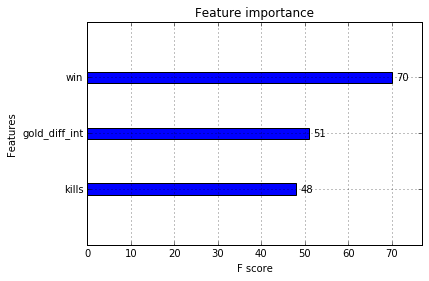

In [724]:
model = xgb.train(best, d_train, num_boost_round=best_n_rounds)
xgb.plot_importance(model)

In [725]:
X_pred_ = X.query('league == "eu_2016_summer"').reset_index()
X_pred = pd.DataFrame()

X_pred['gold_diff_int'] = X_pred_['t1_gold_diff_int'] - X_pred_['t2_gold_diff_int']
X_pred['kills'] = X_pred_['t1_kills'] - X_pred_['t2_kills']
X_pred['win'] = X_pred_['t1_win'] - X_pred_['t2_win']

Y_pred = X_pred_['outcome']
train_pred = xgb.DMatrix(X_pred)

In [726]:
preds = pd.DataFrame()
preds['pred'] = model.predict(train_pred)
preds['outcome'] = Y_pred
preds['t1'] = X_pred_['t1']
preds['t2'] = X_pred_['t2']
preds['date'] = X_pred_['date'].apply(lambda x: x.date())
preds['league'] = X_pred_['league']
preds['match'] = X_pred_['match_id']
preds['game'] = X_pred_['game_id']

In [727]:
# Glicko2 stuff
import math
import glicko2
def glicko2_probability(r1,r2,rd1,rd2):
    return 1.0 / (1.0 + math.pow(10.0, ((r2-r1)/(400.0*math.sqrt(1.0+0.0000100723986*((rd1 ** 2)+(rd2 ** 2)))))))

In [728]:
glicko_teams = {}

for team_name, _ in teams['eu_2016_summer'].iteritems():
    glicko_teams[team_name] = glicko2.Player()

X_glicko = []
    
for _, row in X_.iterrows():
    
    if row[5] == 'eu_2016_summer':
    
        t1 = row[0]
        t2 = row[1]
        outcome = row[6]
        game = row[3]

        pred = glicko2_probability(glicko_teams[t1].rating, glicko_teams[t2].rating, glicko_teams[t1].rd, glicko_teams[t2].rd)
        
        glicko_teams[t1].update_player([glicko_teams[t2].rating], [glicko_teams[t2].rd], [outcome])
        glicko_teams[t2].update_player([glicko_teams[t1].rating], [glicko_teams[t1].rd], [1-outcome])
    
        X_glicko.append([pred, game])
    
glicko_preds = pd.DataFrame(X_glicko, columns=['pred','game'])

In [729]:
preds_ = pd.merge(preds, glicko_preds, on='game')

In [730]:
pickle.dump(preds_, open("eu_summer_2016_preds.p", "wb" ))

In [731]:
log_reg = LogisticRegression()
log_reg.fit(train, Y)
zip(log_reg.coef_[0], d_train.feature_names)

[(1.1092049235058516e-05, u'gold_diff_int'),
 (3.9782770805417814e-11, u'kills'),
 (8.0778185891315141e-11, u'win')]